<a href="https://colab.research.google.com/github/milicak/Data_Analysis_Course/blob/main/04_Correlation_Coefficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import os                                               # to set current working directory
import sys                                              # supress output to screen for interactive variogram modeling
import io
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from matplotlib.pyplot import cm                        # color maps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.patches import Ellipse                  # plot an ellipse
import math                                             # sqrt operator
import random                                           # random simulation locations
from copy import copy                                   # copy a colormap
from scipy.stats import norm
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from scipy.stats import norm                            # Gaussian distribution
import scipy.stats as st                                # statistical methods
from scipy.interpolate import make_interp_spline        # smooth curves
plt.rc('axes', axisbelow=True)                          # set axes and grids in the background for all plots

In [2]:
def add_grid(sub_plot):
    sub_plot.grid(True, which='major',linewidth = 1.0); sub_plot.grid(True, which='minor',linewidth = 0.2) # add y grids
    sub_plot.tick_params(which='major',length=7); sub_plot.tick_params(which='minor', length=4)
    sub_plot.xaxis.set_minor_locator(AutoMinorLocator()); sub_plot.yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

In [7]:
global sample
import warnings; warnings.simplefilter('ignore')

# dashboard: number of simulation locations and variogram parameters
style = {'description_width': 'initial'}
l = widgets.Text(value='                                                     Correlation Coefficient',layout=Layout(width='950px', height='30px'))
ndata = widgets.IntSlider(min = 0, max = 10000, value = 5000, step = 1000, description = r'$n_{samples}$',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
ndata.style.handle_color = 'gray'

corr = widgets.FloatSlider(min = -1.0, max = 1.0, value = 0, step = 0.1, description = r'$\rho_{x_1,x_2}$',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
corr.style.handle_color = 'gray'

cond = widgets.Checkbox(value=False,description='Show Conditionals',disabled=False,indent=False)

raster = widgets.Checkbox(value=False,description='Show Joint',disabled=False,indent=False)

uipars = widgets.HBox([ndata,corr,cond,raster],)

uik = widgets.VBox([l,uipars],)

def f_make(ndata,corr,cond,raster): # function to take parameters, make sample and plot
    global df # Declare df as global
    text_trap = io.StringIO()                           # suppress all text function output to dashboard to avoid clutter
    sys.stdout = text_trap
    cmap = cm.inferno
    np.random.seed(seed = 73072)                        # ensure same results for all runs
    mean = np.array([0,0])
    correl = np.array([[1.0,corr],[corr,1.0]],dtype=float)
    sample = np.random.multivariate_normal(mean,correl,size = ndata)
    df = pd.DataFrame(sample,columns=['X1','X2'])

    #slope, intercept, r_value, p_value, std_err = st.linregress(sample[:,0],sample[:,1])
    #x1 = np.array([-3.0,3.0])
    #x2 = x1*slope + intercept

    plt_scatter = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
    plt_x1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,
                               sharex=plt_scatter)
    plt_x2 = plt.subplot2grid((3, 3), (1, 2), rowspan=2,
                               sharey=plt_scatter)

    #plt.plot([0,0],[1.0,1.0],color = 'black')
    if raster == True:
        plt_scatter.hist2d(df['X1'],df['X2'], bins=30, range=[[-3,3],[-3,3]], density=False, weights=None, cmin=None, cmax=None,
                       cmap=plt.cm.Reds,alpha=1.0,zorder=1)
    else:
        plt_scatter.scatter(sample[:,0],sample[:,1],color = 'red',alpha = 0.2,edgecolors='black',label = 'Samples',zorder=100)
        plt_scatter.legend(loc='upper left')

    plt_scatter.set_xlabel(r'$x_1$'); plt_scatter.set_ylabel(r'$x_2$')
    plt_scatter.set_xlim([-3.0,3.0]); plt_scatter.set_ylim([-3.0,3.0]); add_grid(plt_scatter)


    for x in np.linspace(-3.0,3.0,31):
        plt_scatter.plot([x,x],[-3,3],color='grey',lw=0.2)
        plt_scatter.plot([-3,3],[x,x],color='grey',lw=0.2)

    for x in np.linspace(-2.0,2.0,5):
        plt_scatter.plot([x,x],[-3,3],color='grey',lw=0.5)
        plt_scatter.plot([-3,3],[x,x],color='grey',lw=0.5)


    if cond == True:
        nbins = 6
        X1_new = np.linspace(-2.0,2.0,300)            # for smooth splines
        X1_bins = np.linspace(-2.5,2.5,nbins)            # set the bin boundaries and then the centroids for plotting
        X1_centroids = np.linspace((X1_bins[0]+X1_bins[1])*0.5,(X1_bins[-2]+X1_bins[-1])*0.5,nbins-1)
        df['X1_bins'] = pd.cut(df['X1'], X1_bins,labels = X1_centroids) # cut on bondaries and lable with centroids

        cond_exp = df.groupby('X1_bins')['X2'].mean()
        cond_P90 = df.groupby('X1_bins')['X2'].quantile(.9)
        cond_P10 = df.groupby('X1_bins')['X2'].quantile(.1)

        spl_exp = make_interp_spline(X1_centroids, cond_exp, k=3)
        spl_P90 = make_interp_spline(X1_centroids, cond_P90, k=3)
        spl_P10 = make_interp_spline(X1_centroids, cond_P10, k=3)
        cond_exp_spl = spl_exp(X1_new)
        cond_P90_spl = spl_P90(X1_new)
        cond_P10_spl = spl_P10(X1_new)

        plt_scatter.plot(X1_new,cond_exp_spl,color='white',lw=4,zorder=100)
        plt_scatter.plot(X1_new,cond_exp_spl,color='black',lw=2,zorder=200)
        plt_scatter.plot(X1_new,cond_P90_spl,color='white',lw = 4,zorder=100)
        plt_scatter.plot(X1_new,cond_P90_spl,'r--',color='black',lw = 2,zorder=200)
        plt_scatter.plot(X1_new,cond_P10_spl,color='white',lw = 4,zorder=100)
        plt_scatter.plot(X1_new,cond_P10_spl,'r--',color='black',lw = 2,zorder=200)

        plt_scatter.annotate('Exp',[X1_new[0]-0.3,cond_exp_spl[0]]); plt_scatter.annotate('Exp',[X1_new[-1]+0.05,cond_exp_spl[-1]])
        plt_scatter.annotate('P10',[X1_new[0]-0.3,cond_P10_spl[0]]); plt_scatter.annotate('P10',[X1_new[-1]+0.05,cond_P10_spl[-1]])
        plt_scatter.annotate('P90',[X1_new[0]-0.3,cond_P90_spl[0]]); plt_scatter.annotate('P90',[X1_new[-1]+0.05,cond_P90_spl[-1]])

    counts = plt_x1.hist(sample[:,0],density = True,alpha=0.0,color=None,edgecolor=None,bins=np.linspace(-3.0,3.0,31))[0]
    N, bins, patches = plt_x1.hist(sample[:,0],density = True,alpha=1.0,edgecolor='black',bins=np.linspace(-3.0,3.0,31))
    for i in range(0,30):
        patches[i].set_facecolor(plt.cm.Reds(counts[i]-np.min(counts)/(np.max(counts)-np.min(counts))))

    plt_x1.set_ylim([0.0,0.8]); add_grid(plt_x1)
    plt_x1.set_xlabel(r'$x_1$'); plt_x1.set_ylabel(r'Density')
    plt_x1.set_title(r'Bivariate Standard Gaussian Distributed Data with $\rho =$' + str(np.round(corr,2)) + '.')

    counts = plt_x2.hist(sample[:,1],density = True,alpha=0.0,color=None,edgecolor=None,bins=np.linspace(-3.0,3.0,31))[0]
    N, bins, patches = plt_x2.hist(sample[:,1],orientation='horizontal',density = True,alpha=1.0,edgecolor='black',bins=np.linspace(-3.0,3.0,31))
    for i in range(0,30):
        patches[i].set_facecolor(plt.cm.Reds(counts[i]-np.min(counts)/(np.max(counts)-np.min(counts))))

    #plt_x2.hist(sample[:,1],orientation='horizontal',density = True,color='red',alpha=0.8,edgecolor='black',bins=np.linspace(-3.0,3.0,31))
    plt_x2.set_xlim([0.0,0.8]); add_grid(plt_x2)
    plt_x2.set_ylabel(r'$x_2$'); plt_x2.set_xlabel(r'Density')
    plt_scatter.set_ylabel(r'$x_2$')

    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.7, wspace=0.3, hspace=0.3)
    plt.show()

# connect the function to make the samples and plot to the widgets
interactive_plot = widgets.interactive_output(f_make, {'ndata':ndata,'corr':corr,'cond':cond,'raster':raster})

In [10]:
display(uik, interactive_plot)                            # display the interactive plot

Output()

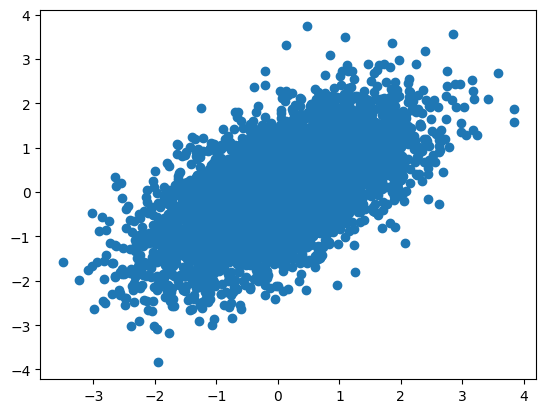

In [11]:
plt.scatter(df['X1'],df['X2'])

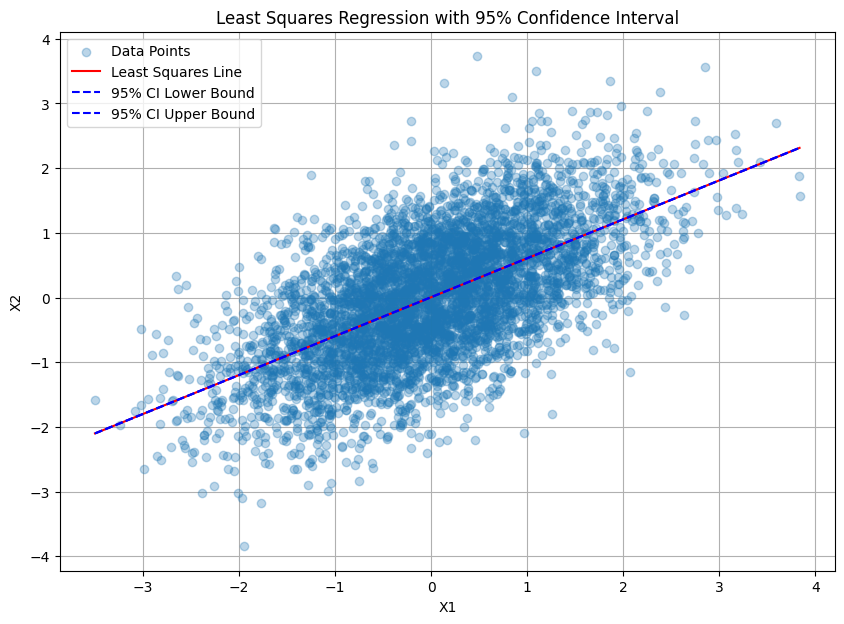

In [13]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

x = df['X1']
y = df['X2']

# Perform linear regression
slope, intercept, r_value, p_value, std_err_estimate = st.linregress(x, y)

# Generate points for the regression line
x_reg = np.linspace(x.min(), x.max(), 100)
y_reg = intercept + slope * x_reg

# Calculate confidence intervals for the regression line
# Degrees of freedom
dof = len(x) - 2

# Critical t-value for 95% confidence
t_critical = st.t.ppf(0.975, dof)

# Calculate the sum of squared differences of X from its mean (Sxx)
S_xx = np.sum((x - np.mean(x))**2)

# Calculate the standard error of the mean prediction for each x_reg value
standard_error_mean_prediction = std_err_estimate * np.sqrt(1/len(x) + (x_reg - np.mean(x))**2 / S_xx)

# Calculate the confidence interval bounds
lower_bound = y_reg - t_critical * standard_error_mean_prediction
upper_bound = y_reg + t_critical * standard_error_mean_prediction

# Plot the scatter data, regression line, and confidence intervals
plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.3, label='Data Points')
plt.plot(x_reg, y_reg, color='red', label='Least Squares Line')
plt.plot(x_reg, lower_bound, color='blue', linestyle='--', label='95% CI Lower Bound')
plt.plot(x_reg, upper_bound, color='blue', linestyle='--', label='95% CI Upper Bound')

plt.title('Least Squares Regression with 95% Confidence Interval')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.show()